In [32]:
import numpy as np
import numpy.ma as ma
import pandas as pd
import os
import gc
import configparser
import json
from datetime import datetime
import time

from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import imagenet_utils

from sklearn.metrics import fbeta_score, precision_score, recall_score

from utils.loaderjpg import *
from utils.visualization import *
from utils.file import *

from pretrained.vgg16 import *
from pretrained.resnet50 import *

In [33]:
config_file = 'cfg/default.cfg'

print('reading configurations from config file: {}'.format(config_file))

settings = configparser.ConfigParser()
settings.read(config_file)
data_dir = settings.get('data', 'data_dir')

rescaled_dim = 224

#model_name = 'vgg16'
model_name = 'resnet50'

reading configurations from config file: cfg/default.cfg


C:\Users\Me\Anaconda2\lib\site-packages\ipykernel\__main__.py:6: DeprecationWarning: You passed a bytestring as `filenames`. This will not work on Python 3. Use `cp.read_file()` or switch to using Unicode strings across the board.


In [34]:
# if not is_training_set_in_cache(rescaled_dim):
#     # populate the training dataset cache
#     df_train = pd.read_csv(data_dir + 'train_v2.csv')
#     load_training_set(df_train, rescaled_dim)

In [35]:
# if not is_test_set_in_cache(rescaled_dim):
#     # populate the test dataset cache
#     df_test = pd.read_csv(data_dir + 'sample_submission_v2.csv')
#     load_test_set(df_test, rescaled_dim)

In [36]:
df_train = pd.read_csv(data_dir + 'train_v2.csv')
x_train, y_train = load_training_set(df_train, rescaled_dim)
print(x_train.shape)
print(y_train.shape)

(40479L, 224L, 224L, 3L)
(40479L, 17L)


(224L, 224L, 3L)


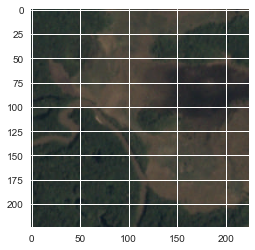

In [37]:
import matplotlib.pyplot as plt
%matplotlib inline

rgb_image = x_train[10]
print(rgb_image.shape)
plt.imshow(cv2.cvtColor(rgb_image, cv2.COLOR_BGR2RGB))

# RGB != BGR.  Resnet expect BGR according to: https://github.com/KaimingHe/deep-residual-networks/issues/5

In [15]:
bottleneck_weights_file = data_dir + 'bottleneck/{}/bottleneck_features.npy'.format(model_name)

if not os.path.exists(bottleneck_weights_file):
# Reference: https://gist.github.com/baraldilorenzo/07d7802847aaad0a35d3
# BGR mean values [103.94, 116.78, 123.68] should be subtracted before feeding into the model
    x_train[:,:,:,0] -= 104
    x_train[:,:,:,1] -= 117
    x_train[:,:,:,2] -= 124

    x_train = x_train.transpose(0,3,1,2)  # https://github.com/fchollet/keras/issues/2681
    print(x_train.shape)

    if model_name == 'vgg16':
        model = vgg16_model_fc_truncated(channel=3)
    elif model_name == 'resnet50':
        model = applications.ResNet50(weights='imagenet', include_top=False)
    else:
        raise ValueError('ERROR: unsupport model {}'.format(model_name))

    train_datagen = ImageDataGenerator()
    train_gen = train_datagen.flow(x_train, y_train, shuffle=False, batch_size=64)

    bottleneck_features = model.predict_generator(train_gen, x_train.shape[0])
    np.save(bottleneck_weights_file, bottleneck_features)

(40479L, 3L, 224L, 224L)


In [17]:
#print(bottleneck_features.shape)
#print(bottleneck_features[1])

(40479L, 2048L, 1L, 1L)
[[[ 0.77592182]]

 [[ 1.37531161]]

 [[ 0.04826033]]

 ..., 
 [[ 0.19254626]]

 [[ 0.06805272]]

 [[ 0.03924479]]]


In [18]:
x_train = np.load(bottleneck_weights_file)

285


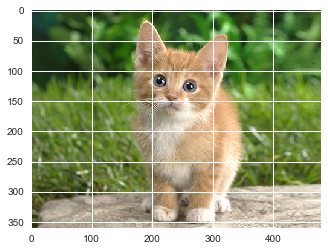

In [42]:
# ## pre-trained model verification
# import matplotlib.pyplot as plt
# %matplotlib inline
# import cv2

# cat = cv2.imread('C:/Users/Me/github/DenseNet-Keras/resources/cat.jpg')

# plt.imshow(cv2.cvtColor(cat, cv2.COLOR_BGR2RGB))

# im = cv2.resize(cat, (224, 224)).astype(np.float32)
# im[:,:,0] -= 103.939
# im[:,:,1] -= 116.779
# im[:,:,2] -= 123.68
# ## im = im[:, :, [2,1,0]] # switch color channel (e.g. by accident) will turn the siamese cat into a red fox
# im = im.transpose((2,0,1))
# im = np.expand_dims(im, axis=0)

# ## Test pretrained model
# if model_name == 'vgg16':
#     infer_model = vgg16_model(channel=3)
# elif model_name == 'resnet50':
#     infer_model = applications.ResNet50(weights='imagenet', include_top=True)

# out = infer_model.predict(im)
# print np.argmax(out)


In [26]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import optimizers

number_of_samples = x_train.shape[0]
one_tenth = int(number_of_samples * 0.10)
                     
x_train_fc, x_valid_fc = x_train[:one_tenth*8], x_train[one_tenth*8:one_tenth*9]
y_train_fc, y_valid_fc = y_train[:one_tenth*8], y_train[one_tenth*8:one_tenth*9]

if model_name == 'vgg16':
    model = custom_fc_layers(x_train.shape[1:], num_classes=17)
elif model_name == 'resnet50':
    model = resnet50_custom_top_classifier(x_train.shape[1:], num_classes=17)
else:
    raise ValueError('ERROR: unsupport model {}'.format(model_name))

# early stopping prevents overfitting on training data
early_stop = EarlyStopping(monitor='val_loss', patience=3, min_delta=0, verbose=0, mode='auto')

file_uuid = time.strftime("%Y%m%d-%H%M%S") 
model_filepath = data_dir + 'bottleneck/vgg16/bottleneck_fc_model_no_early_stop_{}.h5'.format(file_uuid)
# save only the best model, not the latest epoch model.
checkpoint = ModelCheckpoint(model_filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False)

adam = optimizers.Adam(lr=0.0001)

model.compile(loss='binary_crossentropy',
              optimizer=adam,
              metrics=['accuracy', 'recall', 'precision'])

history = model.fit(x_train_fc, y_train_fc,
                    nb_epoch=90,
                    batch_size=64,
                    verbose=1,
                    validation_data=(x_valid_fc, y_valid_fc),
                    callbacks=[checkpoint, early_stop])


Train on 32376 samples, validate on 4047 samples
Epoch 1/90
32376/32376 [==============================] - 5s - loss: 0.2638 - acc: 0.9019 - recall: 0.6825 - precision: 0.7899 - val_loss: 0.1783 - val_acc: 0.9365 - val_recall: 0.7291 - val_precision: 0.8769
Epoch 2/90
32376/32376 [==============================] - 1s - loss: 0.1673 - acc: 0.9387 - recall: 0.7381 - precision: 0.8803 - val_loss: 0.1584 - val_acc: 0.9411 - val_recall: 0.7496 - val_precision: 0.8868
Epoch 3/90
32376/32376 [==============================] - 1s - loss: 0.1538 - acc: 0.9425 - recall: 0.7556 - precision: 0.8886 - val_loss: 0.1508 - val_acc: 0.9426 - val_recall: 0.7646 - val_precision: 0.8825
Epoch 4/90
32376/32376 [==============================]

In [27]:
figures_dir = 'figures/{}/Bottleneck'.format(model_name)
makedirs(figures_dir)

plot_file_path = figures_dir + '/top_classifier_' + file_uuid + '.png'
trainHistoryPlot(plot_file_path, history.history, [], None)

In [40]:
from sklearn.metrics import fbeta_score, precision_score, recall_score

p_valid = model.predict(x_valid_fc, x_valid_fc.shape[0])

y_predictions = (np.array(p_valid) > 0.2).astype(int)

precision_s = precision_score(y_valid_fc, y_predictions, average='samples')
print('>>>> Overall precision score over validation set ' , precision_s)

recall_s = recall_score(y_valid_fc, y_predictions, average='samples')
print('>>>> Overall recall score over validation set ' , recall_s)

f2_score = fbeta_score(y_valid_fc, y_predictions, beta=2, average='samples')
print('>>>> Overall F2 score over validation set ' , f2_score)

('>>>> Overall precision score over validation set ', 0.82464435737230402)
('>>>> Overall recall score over validation set ', 0.9199633473354748)
('>>>> Overall F2 score over validation set ', 0.88579785199431527)
